# Propensify (Propensity Model to identify how likely certain target groups customers respond to the marketing campaign)

### Problem Statement:

#### Are you aware of what, when, and why your customers will make a purchase? Many businesses undertake an intense pursuit to discover these answers, dedicating valuable resources to data-driven campaigns and high-cost strategies - yet the actual outcomes often remain elusive and disappointing.
#### Customer information is considered to be a valuable asset, however its true worth can only be established when it is used. Many companies have large collections of data that appear to be impressive, but upon further examination, they may contain outdated or unimportant information. 
#### Propensity modeling is a method that aims to forecast the chance that individuals, leads, and customers will engage in specific actions. This method uses statistical analysis which takes into account all the independent and confounding factors that impact customer behavior.
#### Suppose you are working for a company as a Data Scientist. Your company is commissioned by an insurance company to develop a tool to optimize their marketing efforts.

#### This project is aimed at building a propensity model to identify potential customers.
### Data:
#### The insurance company has provided you with a historical data set (train.csv). The company has also provided you with a list of potential customers to whom to market (test.csv). From this list of potential customers, you need to determine yes/no whether you wish to market to them. (Note: Ignore any additional columns available other than the listed below in the table)


# Solution:

### The problem above is that of a classification problem. Therefore, we can explore LogisticRegression and XGBoost models for this purpose. The reason to choose these models is that these are robust, widely adopted in the industry, and provide good accuracy.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
propensify_train_orig = pd.read_excel('train.xlsx')
propensify_train = propensify_train_orig.copy(deep=True)
propensify_train.head()

,custAge,profession,marital,schooling,default,housing,loan,contact,month,day_of_week,...,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,responded,profit,id
0,34.0,admin.,single,university.degree,no,no,yes,cellular,apr,wed,...,-1.8,93.075,-47.1,1.498,5099.1,999.0,0.0,no,NaN,1.0
1,31.0,services,single,high.school,no,no,no,cellular,jul,thu,...,1.4,93.918,-42.7,4.968,5228.1,999.0,0.0,no,NaN,2.0
2,NaN,admin.,single,high.school,no,no,no,telephone,jun,NaN,...,1.4,94.465,-41.8,4.961,5228.1,999.0,0.0,no,NaN,3.0
3,52.0,admin.,divorced,university.degree,unknown,yes,no,cellular,jul,tue,...,1.4,93.918,-42.7,4.962,5228.1,999.0,0.0,no,NaN,4.0
4,39.0,blue-collar,single,NaN,unknown,yes,no,cellular,jul,tue,...,1.4,93.918,-42.7,4.961,5228.1,999.0,0.0,no,NaN,5.0


In [2]:
propensify_train_orig.columns

Index(['custAge', 'profession', 'marital', 'schooling', 'default', 'housing',
       'loan', 'contact', 'month', 'day_of_week', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'pmonths', 'pastEmail',
       'responded', 'profit', 'id'],
      dtype='object')

# EDA

In [3]:
print("Column Details: ")
print("-----------------------------------------------")
print(propensify_train.info())
print("\n")
print("Number of rows and columns: ")
print("-----------------------------------------------")
print(propensify_train.shape)
print("\n")
print("Missing Values: ")
print("-----------------------------------------------")
print(propensify_train.isna().mean()*100)

Column Details: 
-----------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8240 entries, 0 to 8239
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   custAge         6224 non-null   float64
 1   profession      8238 non-null   object 
 2   marital         8238 non-null   object 
 3   schooling       5832 non-null   object 
 4   default         8238 non-null   object 
 5   housing         8238 non-null   object 
 6   loan            8238 non-null   object 
 7   contact         8238 non-null   object 
 8   month           8238 non-null   object 
 9   day_of_week     7451 non-null   object 
 10  campaign        8238 non-null   float64
 11  pdays           8238 non-null   float64
 12  previous        8238 non-null   float64
 13  poutcome        8238 non-null   object 
 14  emp.var.rate    8238 non-null   float64
 15  cons.price.idx  8238 non-null   float64
 16  cons.conf.idx

### We would drop the column "profit" since it is 88% null, and therefore will not contribute towards the analysis.

In [4]:
propensify_train = propensify_train.drop(["profit"], axis=1)
propensify_train=propensify_train.dropna()
print(propensify_train.shape)

(3965, 23)


In [5]:
dependent = "responded"
all_cols = list(propensify_train.columns)
independent=all_cols
independent.remove(dependent)

<Axes: xlabel='responded', ylabel='count'>

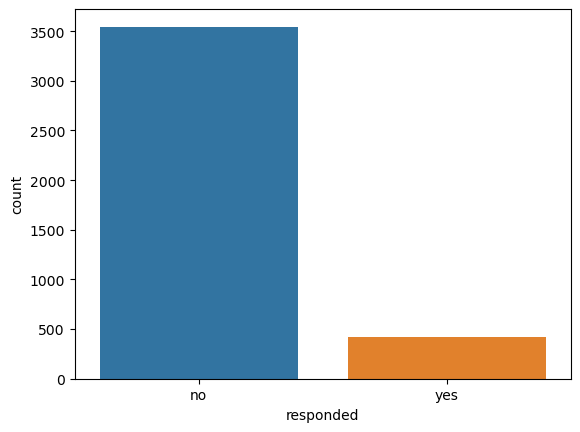

In [6]:
sns.countplot(data=propensify_train, x=dependent)

### We will categorize the columns to treat them appropriately in Feature Engineering.

In [7]:



def classify_cols(df):
    
    numerical = df.select_dtypes(include=['number']).columns
    categorical = df.select_dtypes(exclude=['number']).columns

    binary_cols=[]
    for col in numerical:
        unique_vals = df[col].unique()
        if np.in1d(unique_vals, [0,1]).all():
            binary_cols.append(col)
            
    binary_cols_from_cat_cols = []
    for col in categorical:
        if df[col].nunique()==2:
            binary_cols_from_cat_cols.append(col)
            
    allBinary = list(set(binary_cols).union(set(binary_cols_from_cat_cols)))
    multiclass_cols = list(set(categorical) - set(allBinary))
    
    return list(set(numerical)-set(binary_cols)), list(categorical), list(binary_cols), binary_cols_from_cat_cols, multiclass_cols
       
#time_col = "Year"

numerical, categorical, binary, binary_cols_from_cat_cols, multiclass_cols = classify_cols(propensify_train)

#binarycols = binary_cols(propensify_train, numerical)
#binary_cols_from_cat_cols = binary_cols_from_cat_cols(propensify_train, categorical)
#categorical.append(time_col)
#numerical.remove(time_col)
#categorical.append('Owner')
#numerical.remove('Owner')


#allBinary = list(set(binary).union(set(binary_cols_from_cat_cols)))
#multiclass_cols = list(set(categorical) - set(allBinary))

print(numerical)
print(categorical)
print(binary)
print(binary_cols_from_cat_cols)
print(multiclass_cols)

['id', 'pdays', 'emp.var.rate', 'pmonths', 'cons.conf.idx', 'custAge', 'campaign', 'pastEmail', 'nr.employed', 'previous', 'cons.price.idx', 'euribor3m']
['profession', 'marital', 'schooling', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'responded']
[]
['contact', 'responded']
['schooling', 'loan', 'day_of_week', 'housing', 'default', 'profession', 'marital', 'month', 'poutcome']


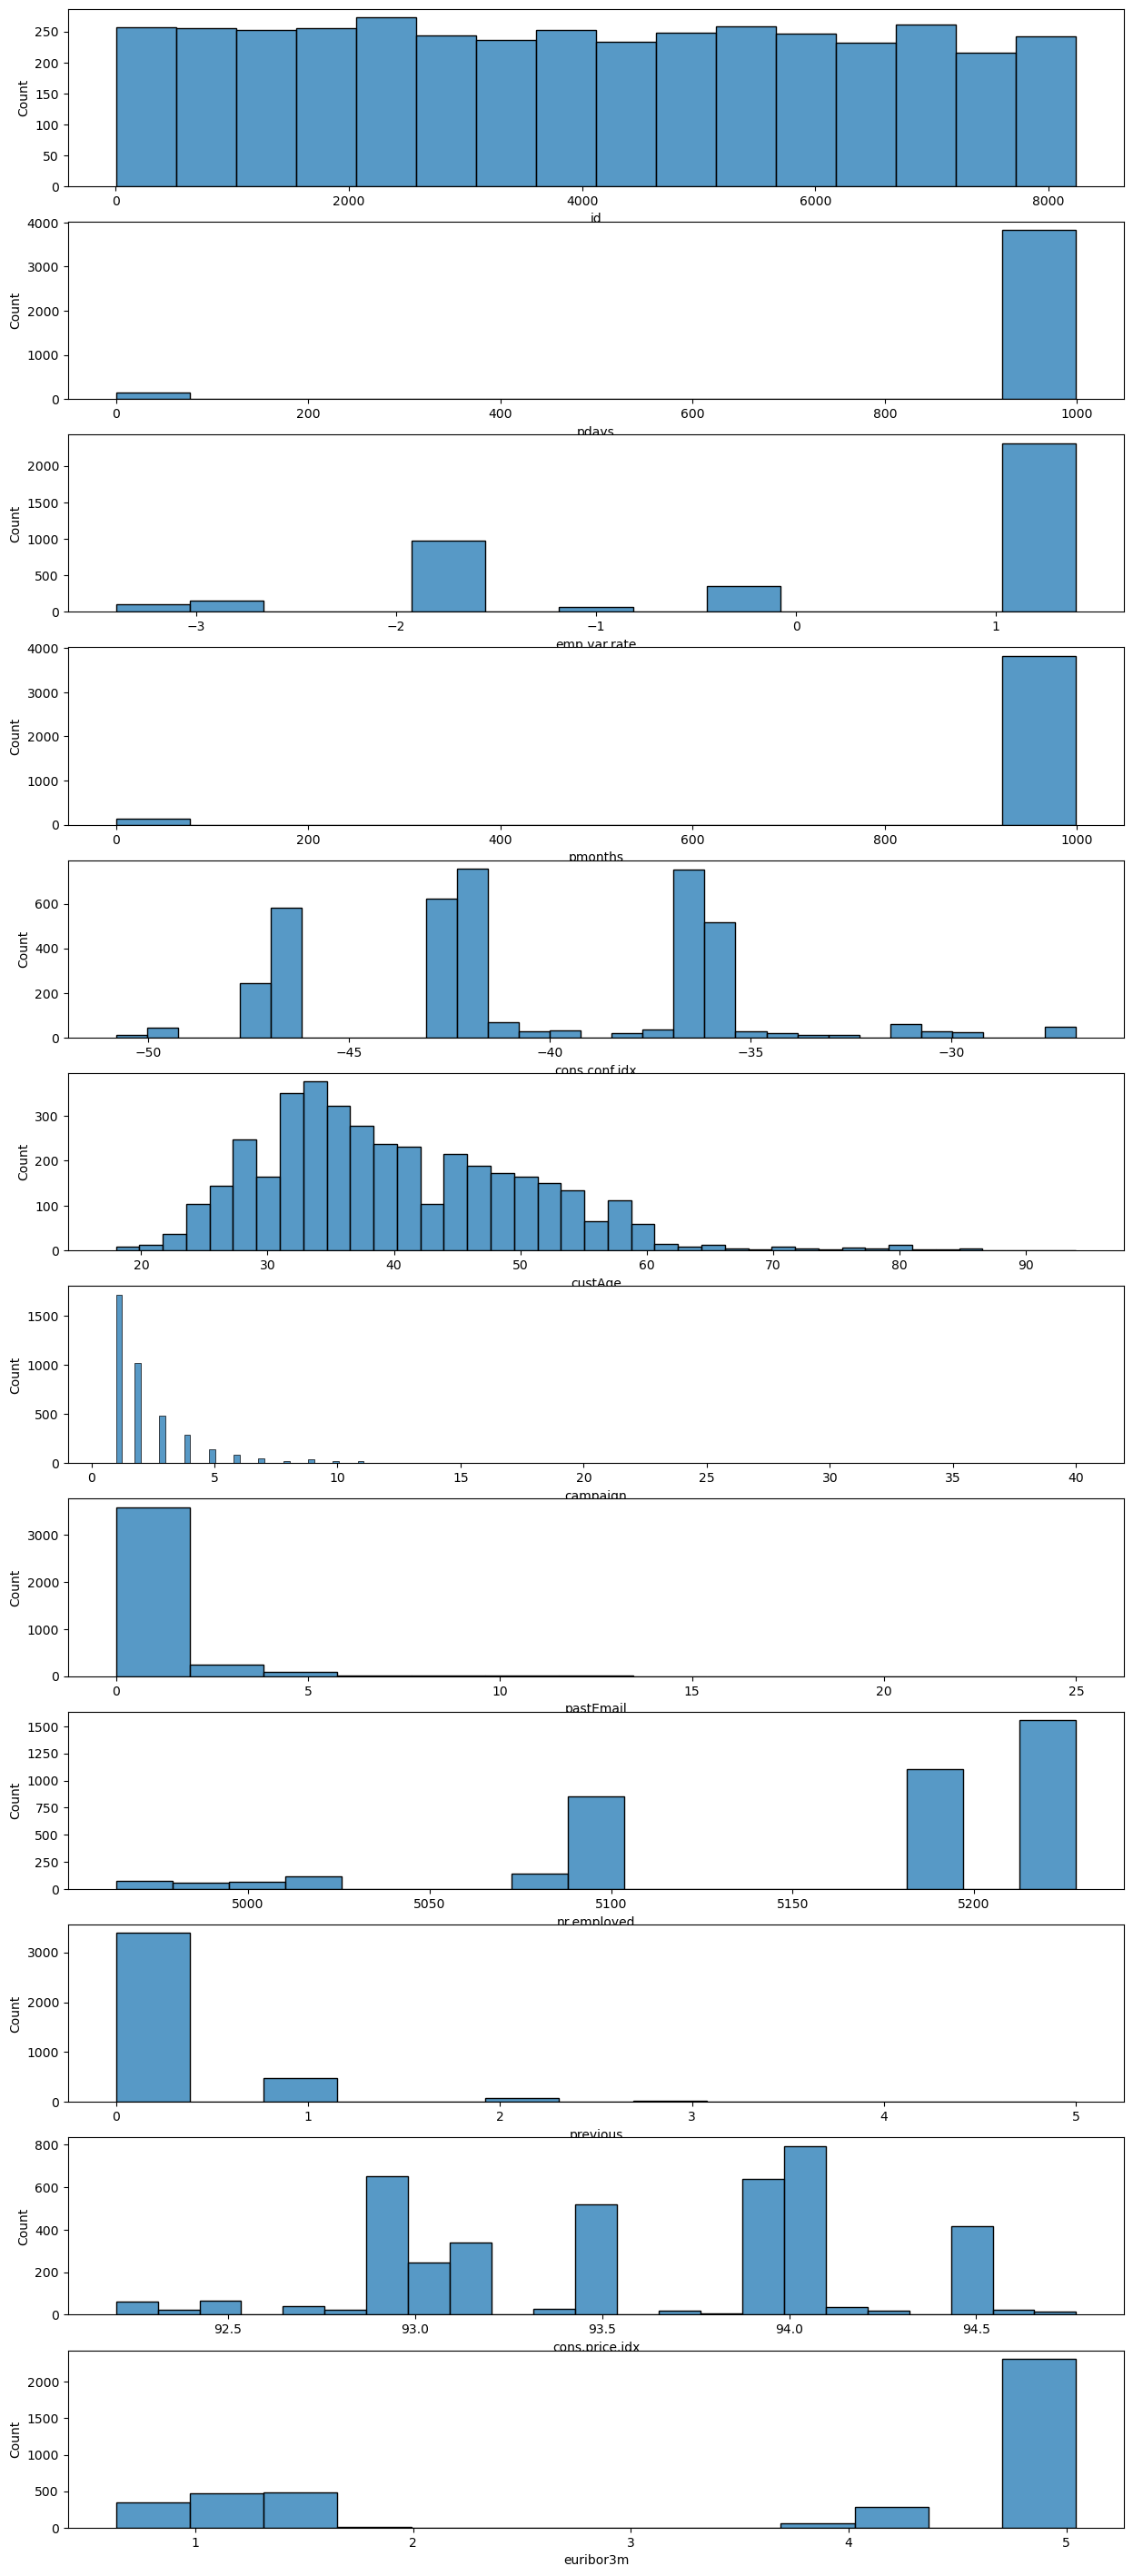

In [8]:
P=1
n_rows = 0

if len(numerical)%P == 0:
    n_rows = len(numerical)//P
else:
    n_rows = len(numerical)//P + 1


fig, axes = plt.subplots(n_rows, P, figsize=(15, n_rows * 3))

i=0
for num_col in numerical:
    ax = axes[i]
    row = i // P
    col = i % P

    # Plot Seaborn histogram
    sns.histplot(x=num_col, data=propensify_train, ax=ax)
    
    #ax.set_title(num_col)
    
    i = i+1


plt.show()


C:\Users\debde\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


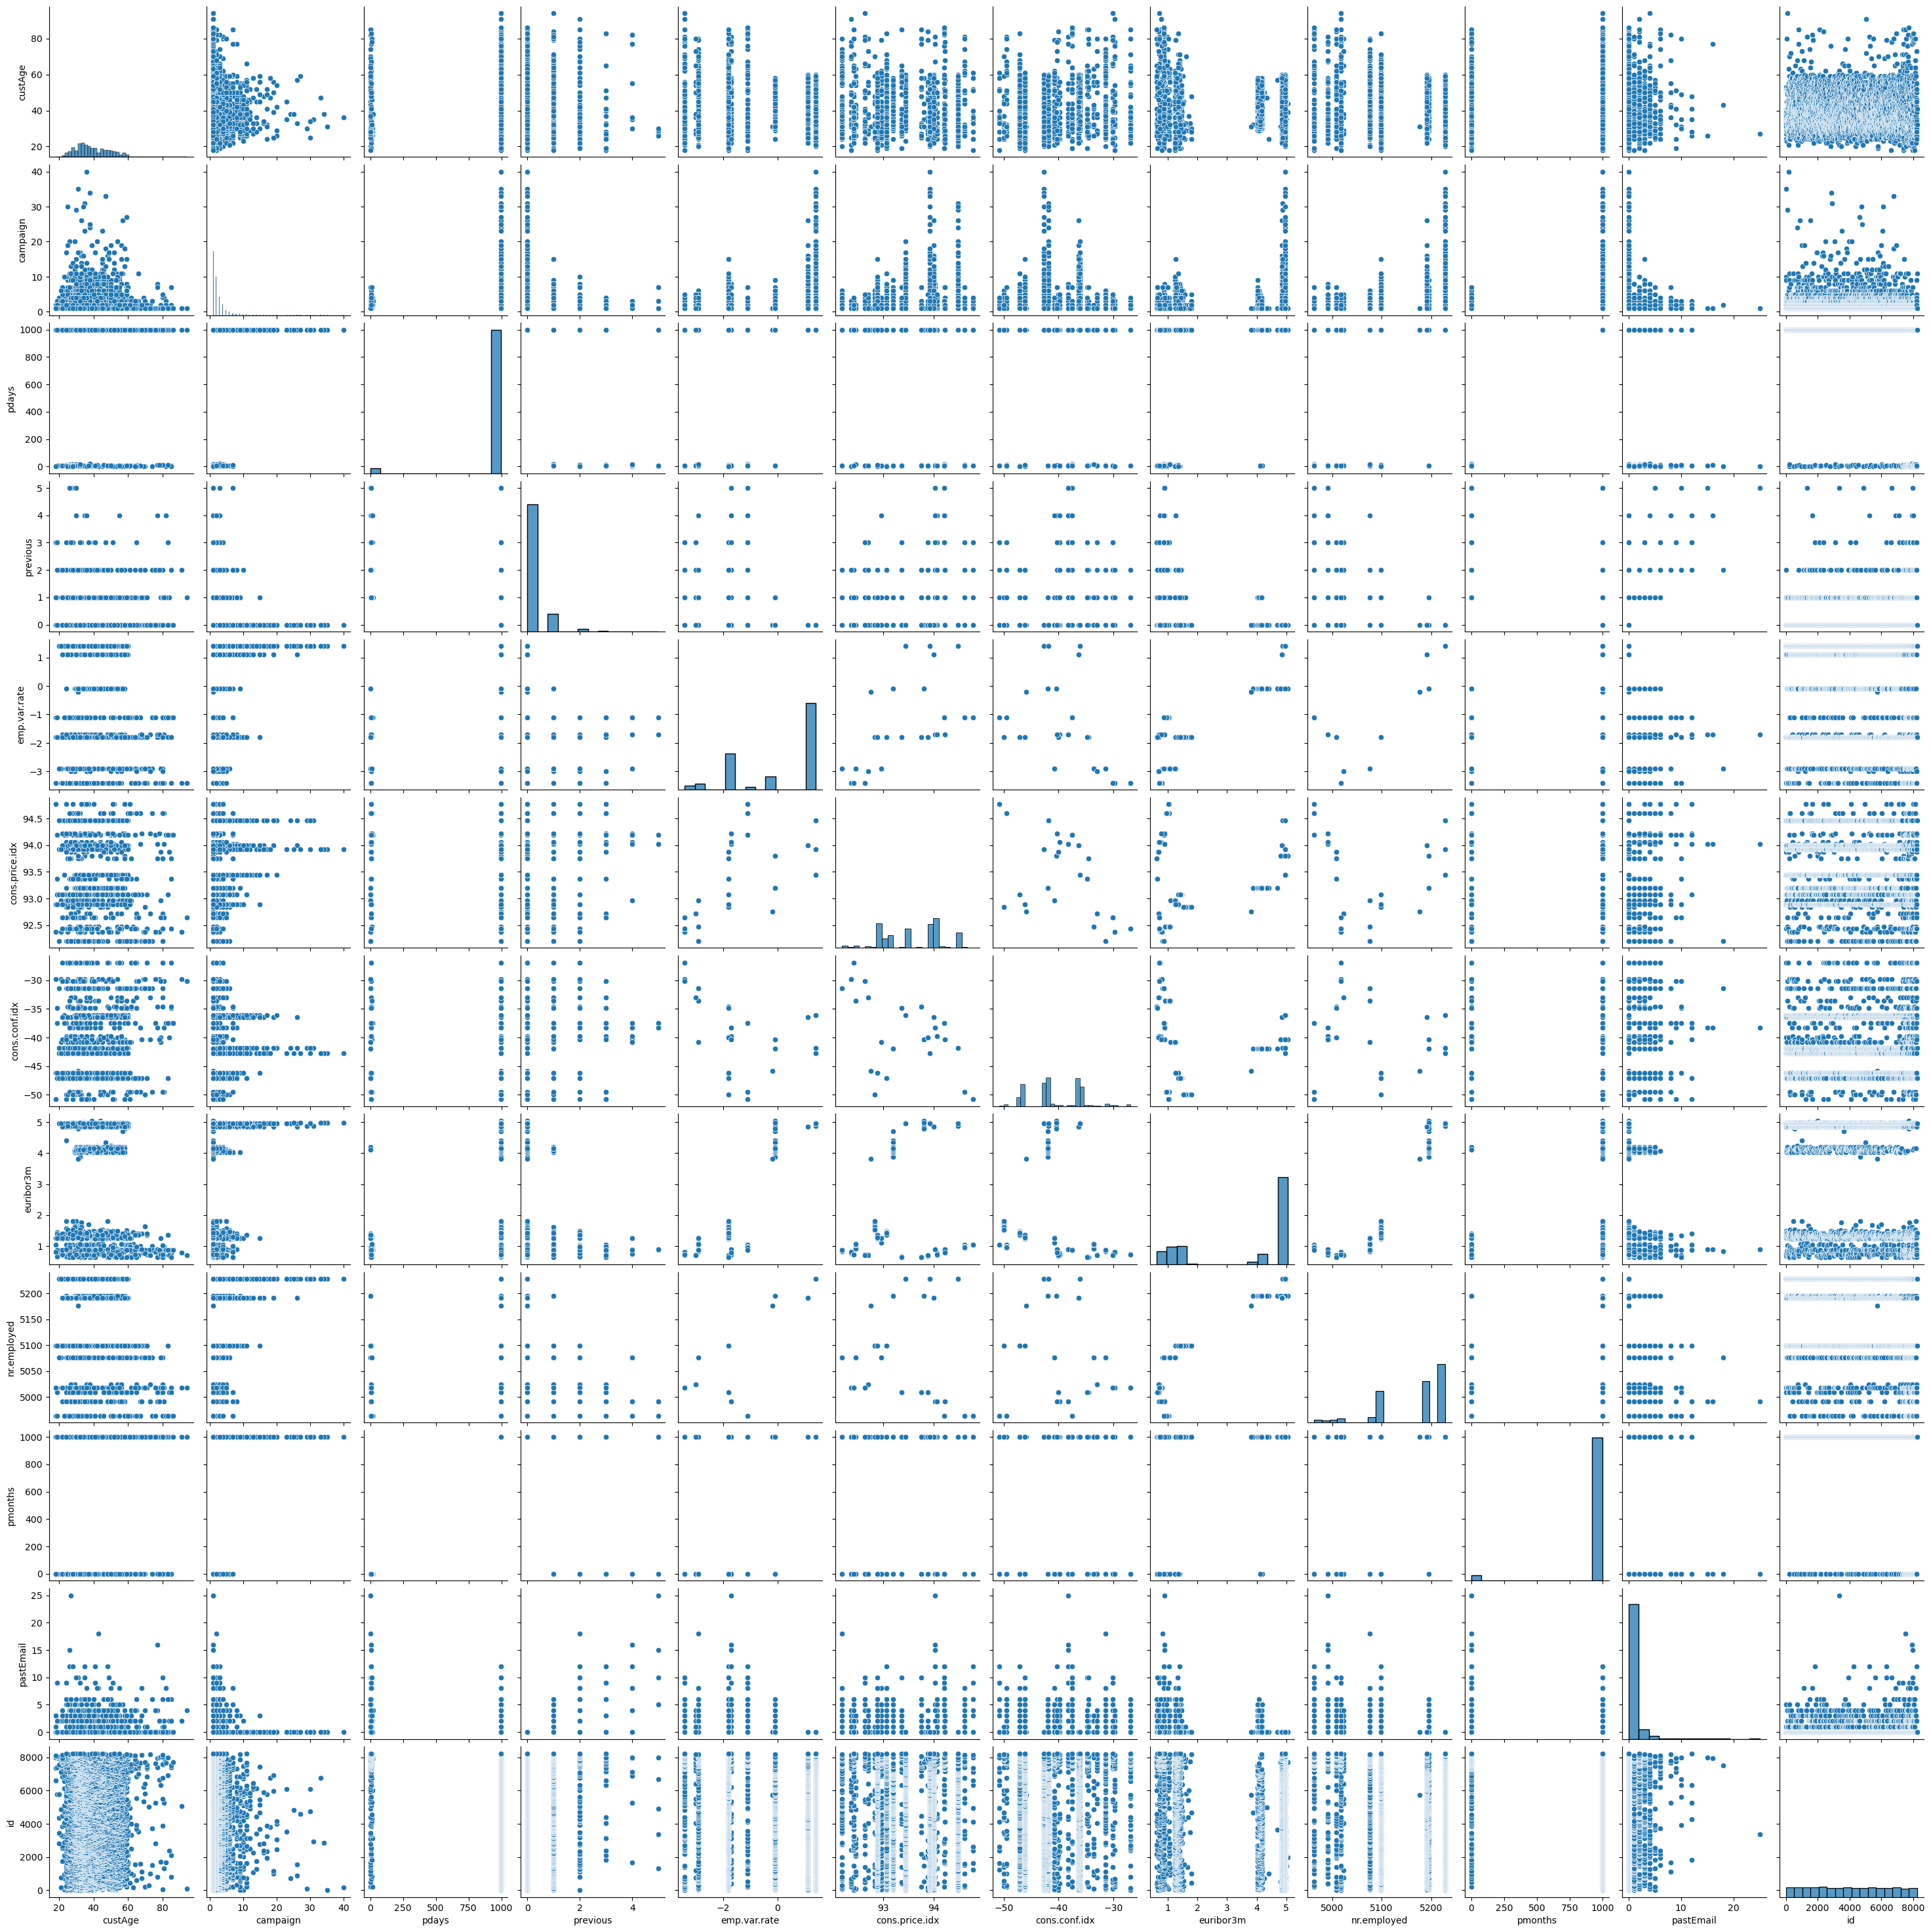

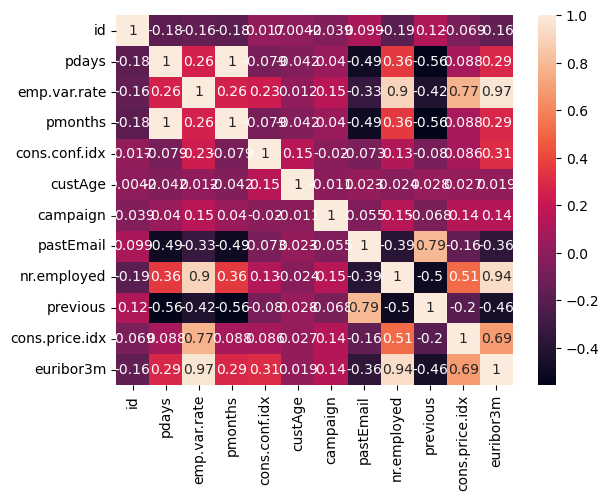

In [9]:
sns.pairplot(propensify_train)
plt.show()
sns.heatmap(propensify_train[numerical].corr(), annot = True)
plt.show()

### Columns "pdays" and "pmonths" are perfectly correlated. We could drop any one of them now, but this would be automatically done during Feature Selection step.

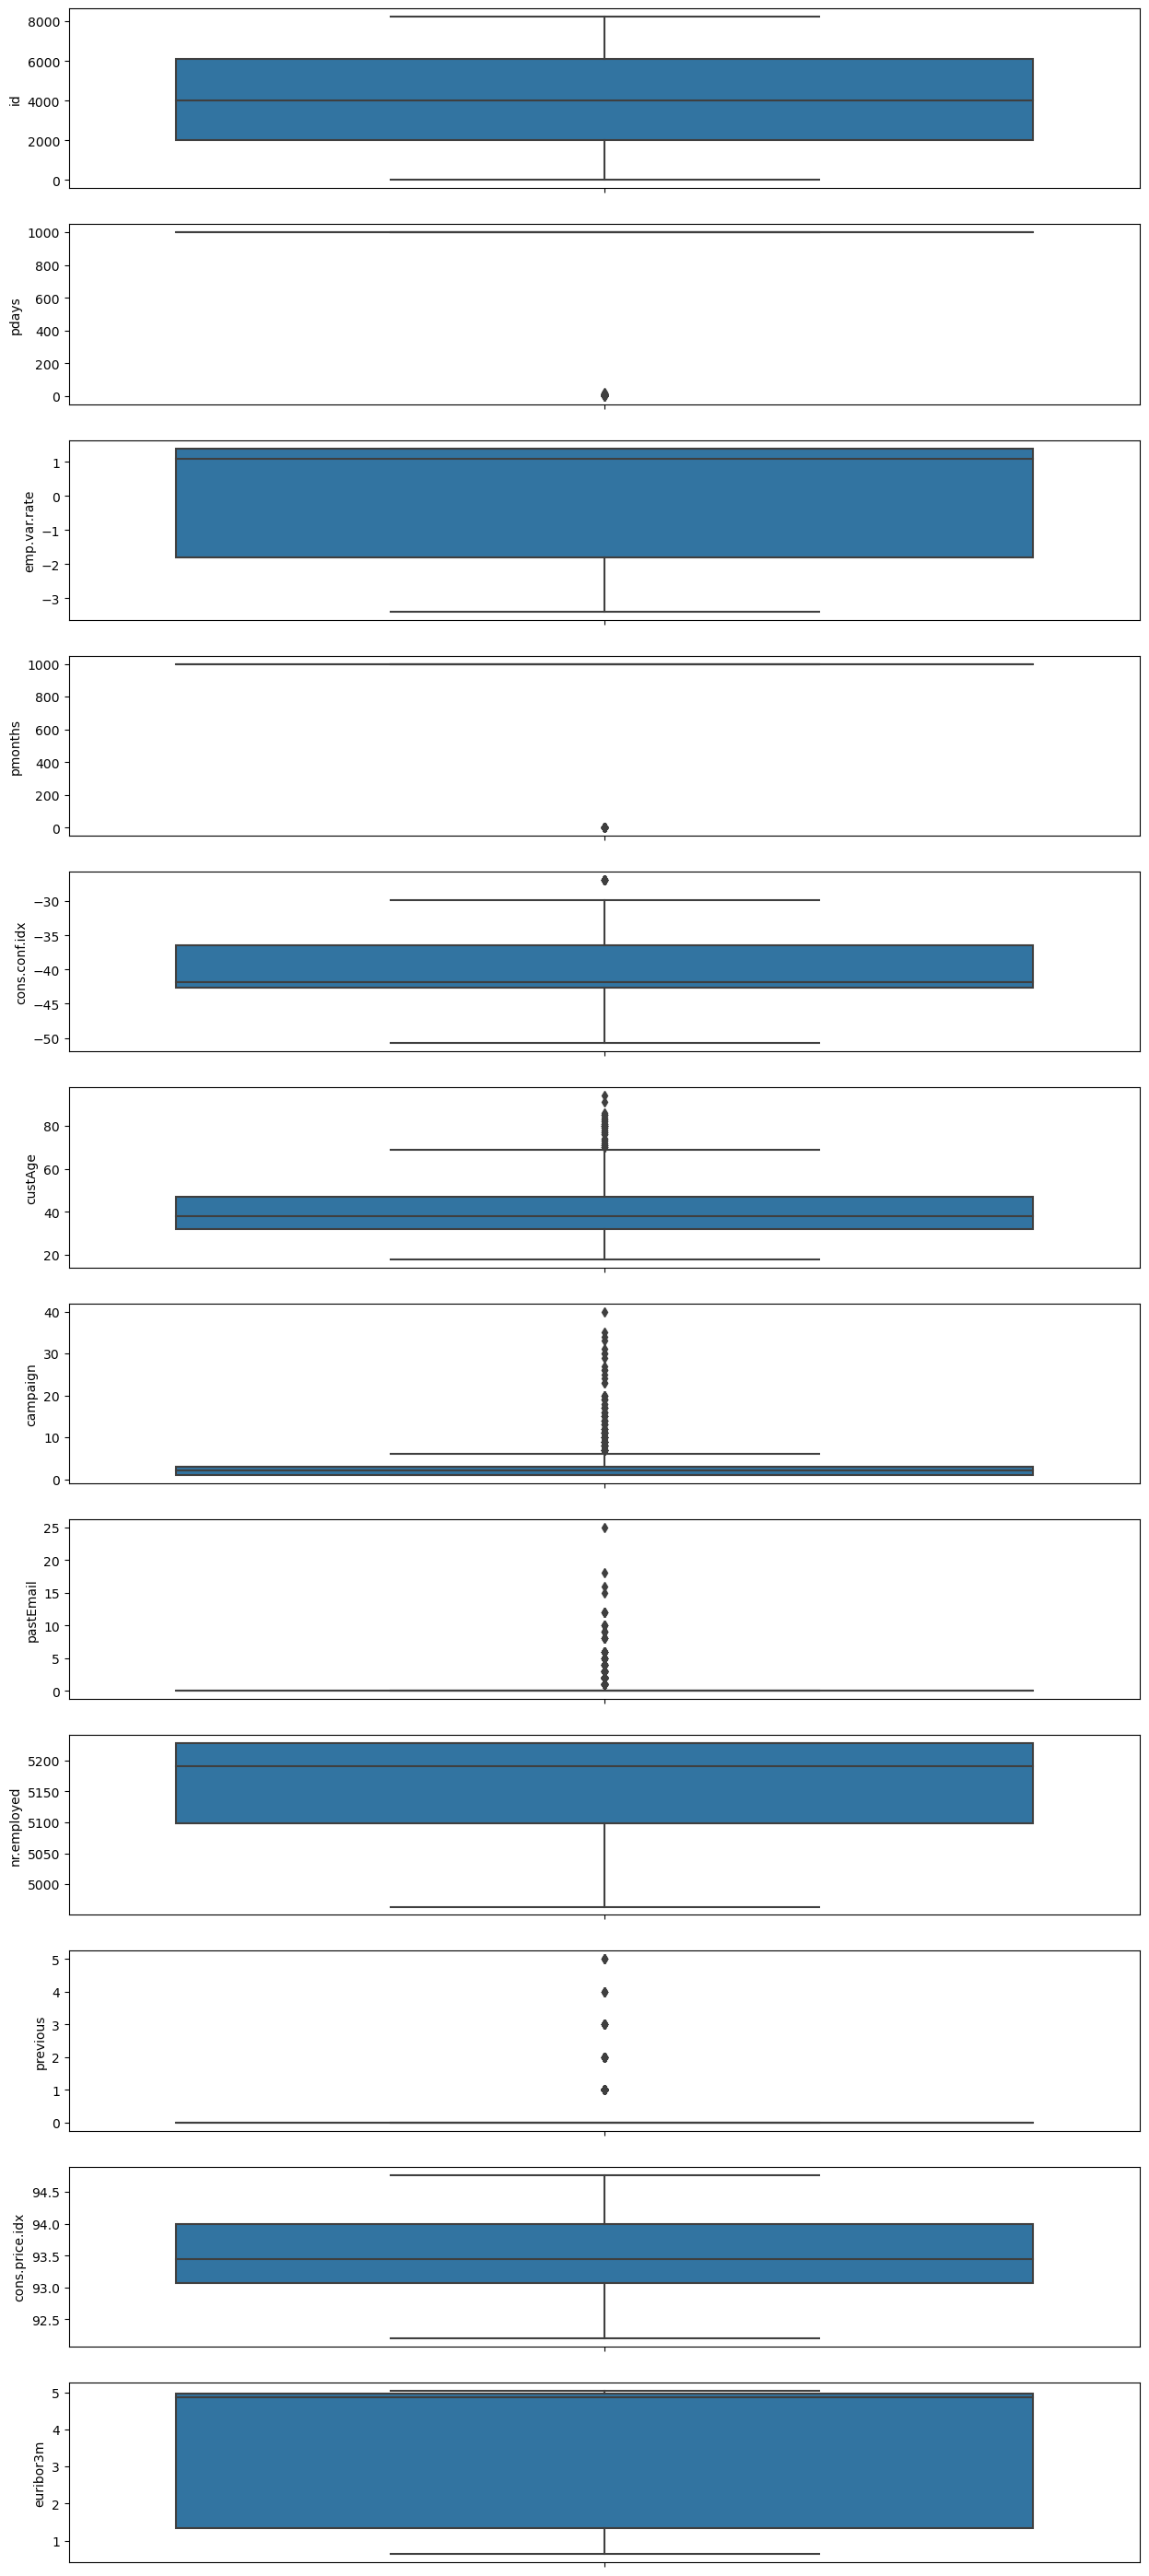

In [10]:
P=1
n_rows = 0

if len(numerical)%P == 0:
    n_rows = len(numerical)//P
else:
    n_rows = len(numerical)//P + 1


fig, axes = plt.subplots(n_rows, P, figsize=(15, n_rows * 3))

i=0
for num_col in numerical:
    ax = axes[i]
    row = i // P
    col = i % P

    # Plot Seaborn histogram
    sns.boxplot(data=propensify_train, y=num_col, ax=ax)
    #ax.set_title(num_col)
    
    i = i+1


plt.show()



### From the above box-plots, we see that there are lots of outliers for each numerical attribute. These can lead to overfitting of the model, and lead to reduced prediction accuracy. Therefore, we would remove the outliers.

In [11]:
def outlier_treatment(df, numerical):
    df1=df
    outlier_df = pd.DataFrame(columns=list(df.columns))
    
    for column_name in numerical:
        
        
        # Calculate quartiles and IQR for the current column
        q1 = float(df[column_name].quantile(0.25))
        q3 = float(df[column_name].quantile(0.75))
        iqr = q3 - q1

        # Define the lower and upper bounds for identifying outliers
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Create a mask for the current column
        outlier_mask = (df[column_name] < lower_bound) | (df[column_name] > upper_bound)

        # Mark outliers in the outlier_df DataFrame
        df2=df.loc[outlier_mask]
        df=df.loc[~outlier_mask]
        
        outlier_df=pd.concat([outlier_df, df2], ignore_index=True)

    return df, outlier_df


p_train_wo_outliers, outliers = outlier_treatment(propensify_train, numerical) 
#print(len(df_rem)+len(outliers))
p_train_wo_outliers.shape

(2131, 23)

<Axes: xlabel='responded', ylabel='count'>

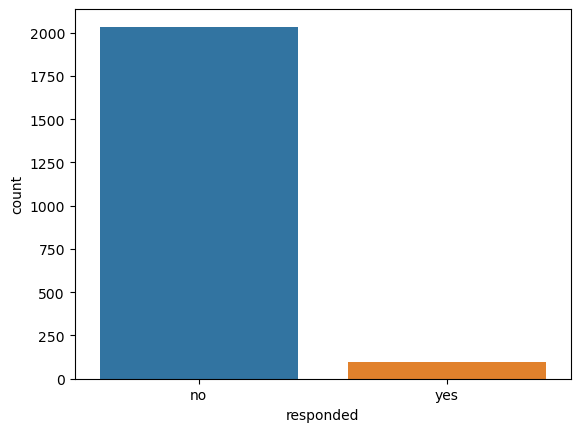

In [12]:
sns.countplot(x=p_train_wo_outliers[dependent])

### From the above chart, we see that the distribution of the target variable is imbalanced. Therefore, we would use oversampling to balance it out,

2131
2131
4068
4068


,custAge,profession,marital,schooling,default,housing,loan,contact,month,day_of_week,...,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,id,responded
0,52.0,admin.,divorced,university.degree,unknown,yes,no,cellular,jul,tue,...,nonexistent,1.4,93.918,-42.7,4.962,5228.1,999.0,0.0,4.0,no
1,29.0,technician,married,professional.course,no,yes,no,cellular,aug,mon,...,nonexistent,1.4,93.444,-36.1,4.965,5228.1,999.0,0.0,10.0,no
2,33.0,blue-collar,married,unknown,no,no,no,cellular,jul,mon,...,nonexistent,1.4,93.918,-42.7,4.960,5228.1,999.0,0.0,12.0,no
3,37.0,admin.,single,university.degree,no,no,yes,cellular,aug,mon,...,nonexistent,1.4,93.444,-36.1,4.965,5228.1,999.0,0.0,20.0,no
4,33.0,admin.,married,high.school,no,yes,yes,telephone,may,thu,...,nonexistent,1.1,93.994,-36.4,4.855,5191.0,999.0,0.0,21.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4063,33.0,self-employed,married,basic.9y,unknown,no,no,cellular,aug,fri,...,nonexistent,1.4,93.444,-36.1,4.966,5228.1,999.0,0.0,8067.0,yes
4064,38.0,admin.,single,university.degree,unknown,no,no,telephone,jun,tue,...,nonexistent,1.4,94.465,-41.8,4.961,5228.1,999.0,0.0,7793.0,yes
4065,30.0,self-employed,married,basic.9y,no,no,no,telephone,may,tue,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,999.0,0.0,8157.0,yes
4066,50.0,management,married,university.degree,unknown,yes,no,cellular,aug,mon,...,nonexistent,1.4,93.444,-36.1,4.965,5228.1,999.0,0.0,8189.0,yes


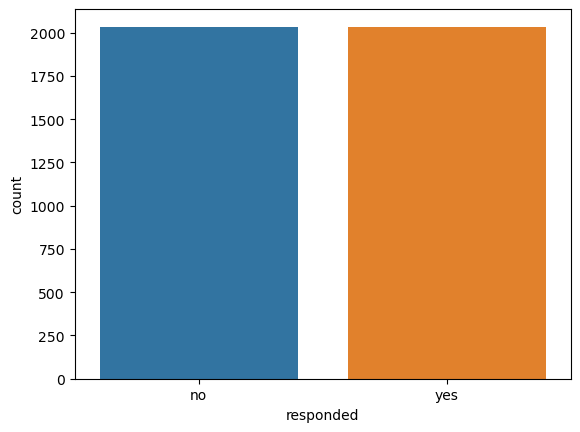

In [13]:
import numpy as np
import pandas as pd


def overSampler(X_train, y_train):
    
    from imblearn.over_sampling import RandomOverSampler


    # Oversampling
    ros = RandomOverSampler(random_state=42)
    x_oversampled, y_oversampled = ros.fit_resample(X_train, y_train)

    print(len(X_train))
    print(len(y_train))
    print(len(x_oversampled))
    print(len(y_oversampled))


    """p_train = x_oversampled
    p_train["responded"] = y_oversampled
    p_train.shape"""
    
    return x_oversampled, y_oversampled
    
X_train = p_train_wo_outliers.drop(dependent, axis=1)
y_train = p_train_wo_outliers[dependent]

X_train, y_train = overSampler(X_train, y_train)
sns.countplot(x=y_train)

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

p_train = pd.concat([X_train,y_train], axis=1)

p_train

### Distribution in the target variable has been balanced after over-sampling. However, this could lead to overfitting of the model.

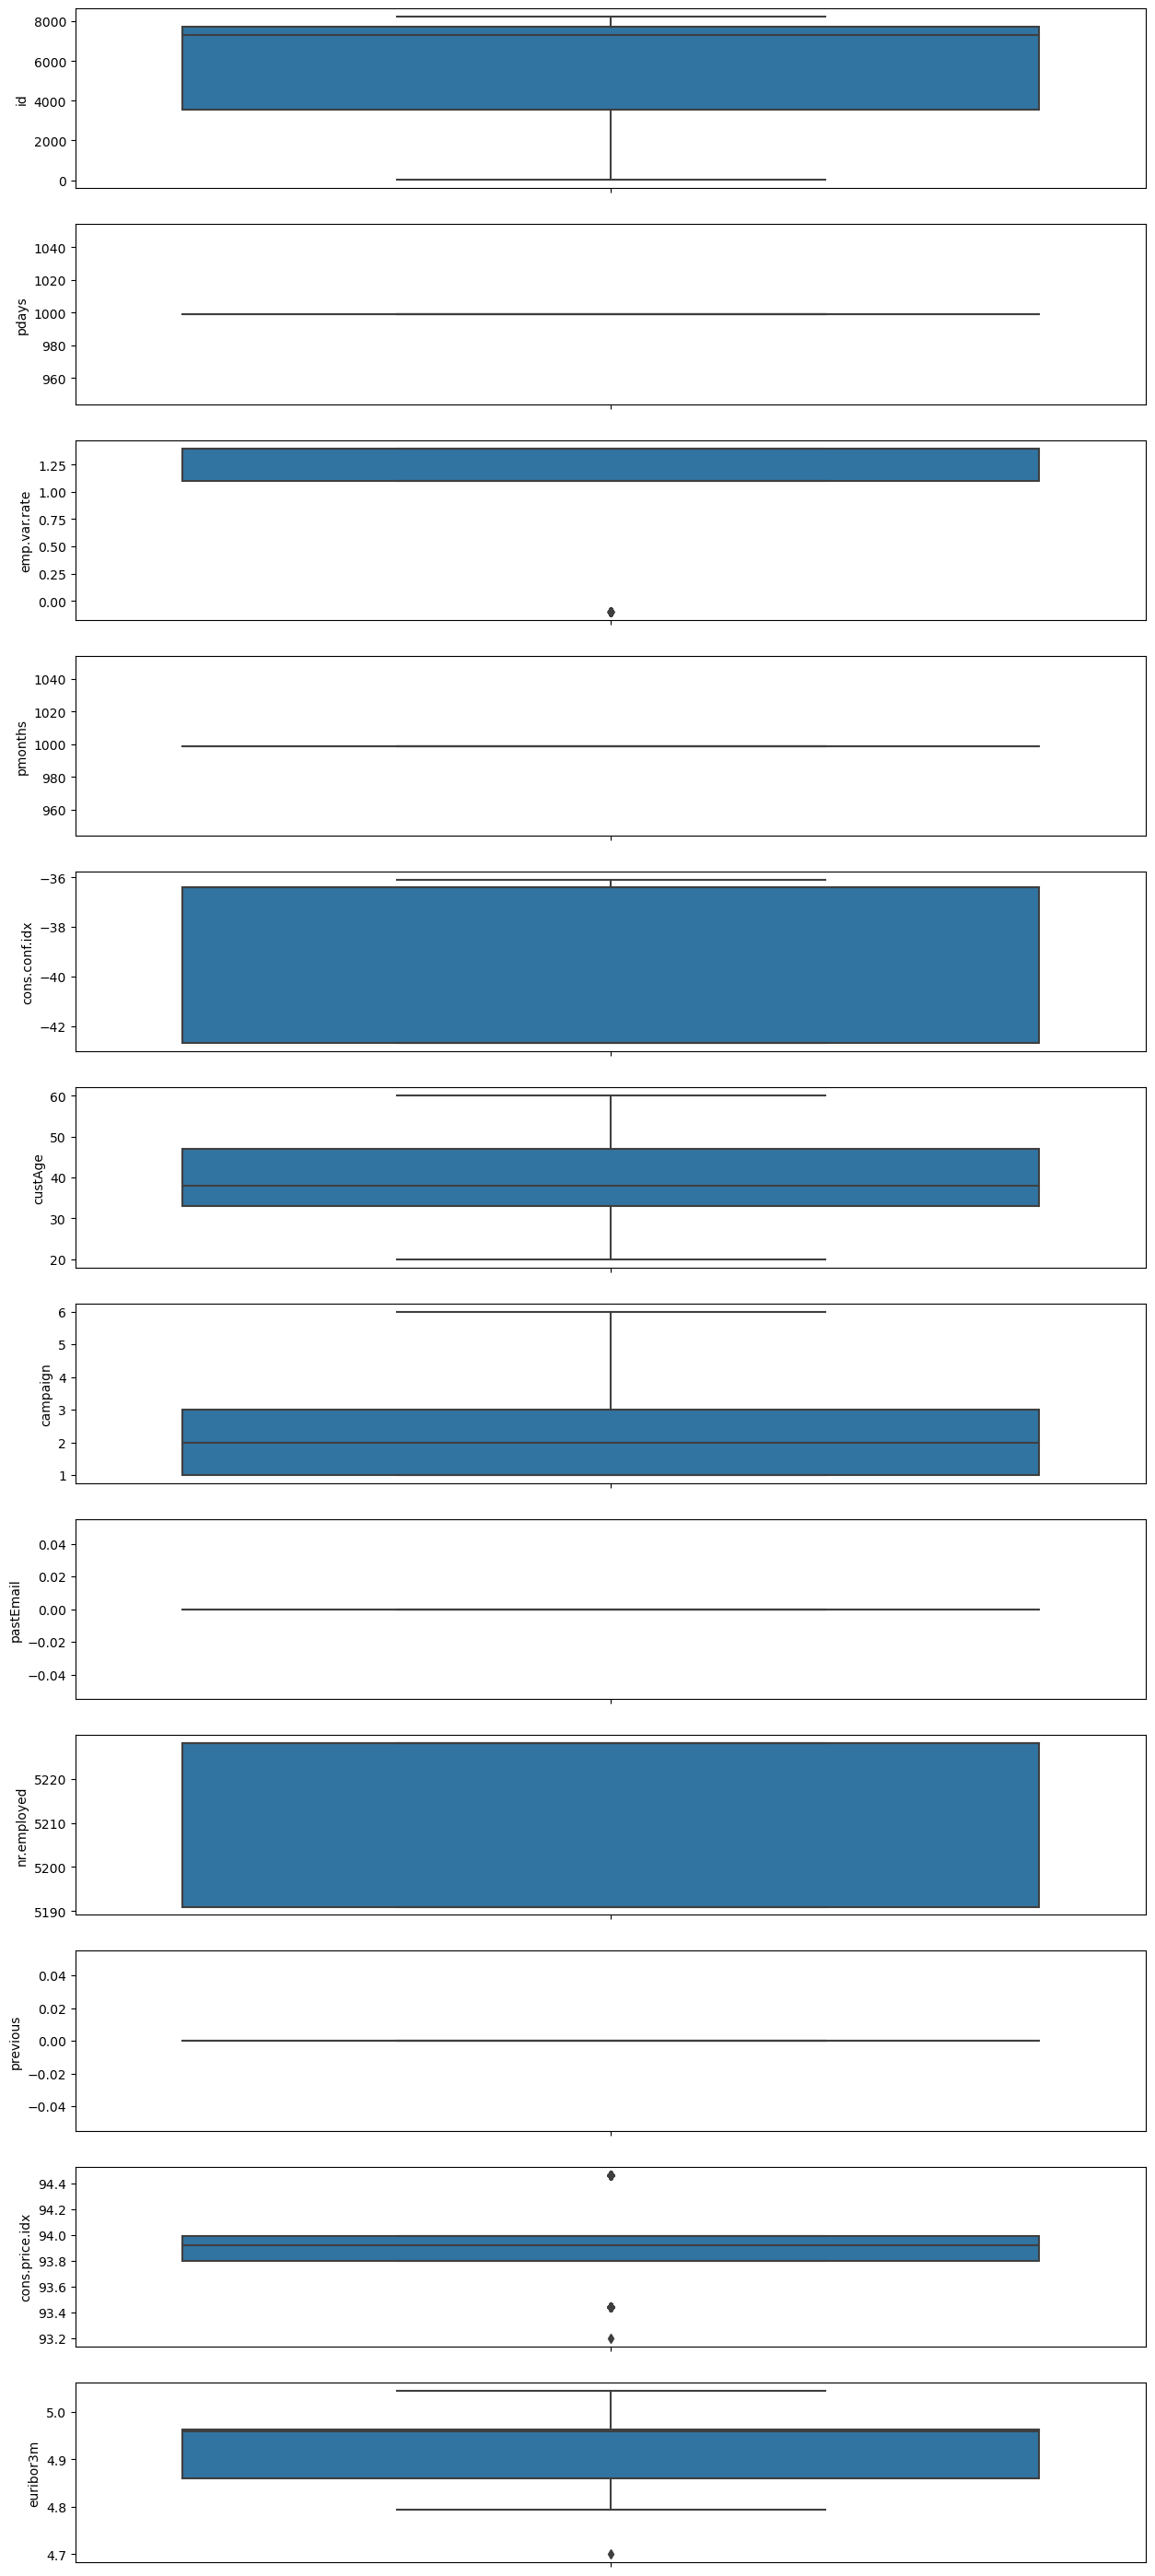

In [14]:
P=1
n_rows = 0

if len(numerical)%P == 0:
    n_rows = len(numerical)//P
else:
    n_rows = len(numerical)//P + 1


fig, axes = plt.subplots(n_rows, P, figsize=(15, n_rows * 3))

i=0
for num_col in numerical:
    ax = axes[i]
    row = i // P
    col = i % P

    # Plot Seaborn histogram
    sns.boxplot(data=p_train, y=num_col, ax=ax)
    #ax.set_title(num_col)
    
    i = i+1


plt.show()



### From the box plots above, we see that the number of outliers have also reduced after the outlier treatment.

# Feature engineering

## Encoding - Multiclass categorical

In [15]:
categories = []
for col in multiclass_cols:
    categories.append(p_train[col].unique())
    
categories

[array(['university.degree', 'professional.course', 'unknown',
        'high.school', 'basic.9y', 'basic.6y', 'basic.4y'], dtype=object),
 array(['no', 'yes', 'unknown'], dtype=object),
 array(['tue', 'mon', 'thu', 'fri', 'wed'], dtype=object),
 array(['yes', 'no', 'unknown'], dtype=object),
 array(['unknown', 'no'], dtype=object),
 array(['admin.', 'technician', 'blue-collar', 'unemployed', 'student',
        'management', 'entrepreneur', 'services', 'housemaid', 'retired',
        'self-employed', 'unknown'], dtype=object),
 array(['divorced', 'married', 'single', 'unknown'], dtype=object),
 array(['jul', 'aug', 'may', 'jun', 'oct', 'nov'], dtype=object),
 array(['nonexistent'], dtype=object)]

In [16]:
""""if dependent in multiclass_cols:
    multiclass_cols.remove(dependent)
if dependent in binary:
    binary.remove(dependent)
if dependent in numerical:
    numerical.remove(dependent)
if dependent in binary_cols_from_cat_cols:
    binary_cols_from_cat_cols.remove(dependent)"""


#mapping = {'Yes': 1, 'No': 0}

# Apply mapping to the column
#p_train[dependent]

'"if dependent in multiclass_cols:\n    multiclass_cols.remove(dependent)\nif dependent in binary:\n    binary.remove(dependent)\nif dependent in numerical:\n    numerical.remove(dependent)\nif dependent in binary_cols_from_cat_cols:\n    binary_cols_from_cat_cols.remove(dependent)'

In [17]:
from sklearn.preprocessing import TargetEncoder

target_encoder = TargetEncoder()
multiclass_features = pd.DataFrame(target_encoder.fit_transform(p_train[multiclass_cols], p_train[dependent]), columns = multiclass_cols)


## Encoding - Binary Categorical

In [18]:
from sklearn.preprocessing import LabelEncoder

binaryFromCat = p_train[binary_cols_from_cat_cols].copy(deep=True)

labelEncoders = []
for col in binary_cols_from_cat_cols:
    encoder = LabelEncoder()
    binaryFromCat[col] = encoder.fit_transform(binaryFromCat[col])
    labelEncoders.append(encoder)

## Feature Scaling

In [19]:
from sklearn.preprocessing import StandardScaler

sc_multiclass = StandardScaler()
multiclass_features = pd.DataFrame(sc_multiclass.fit_transform(multiclass_features), columns = multiclass_cols)
sc_numerical = StandardScaler()
numerical_features = pd.DataFrame(sc_numerical.fit_transform(p_train[numerical]), columns = numerical)




In [20]:
binary_features = p_train[binary]

numerical_features.reset_index(drop=True, inplace=True)
binaryFromCat.reset_index(drop=True, inplace=True)
multiclass_features.reset_index(drop=True, inplace=True)
binary_features.reset_index(drop=True, inplace=True)

p_train = pd.concat([numerical_features,binary_features,binaryFromCat, multiclass_features], axis=1)

In [21]:
binary_cols_from_cat_cols

['contact', 'responded']

# Feature selection

In [22]:

all_cols = list(p_train.columns)
independent=all_cols
independent.remove(dependent)

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

selector = RFECV(estimator = model, min_features_to_select=3, scoring="f1", cv=5)

In [23]:
X_train = p_train[independent]
y_train = p_train[dependent]
selector.fit(X_train, y_train)

RFECV(cv=5, estimator=LogisticRegression(), min_features_to_select=3,
      scoring='f1')

In [24]:
X_train.columns[selector.support_]

Index(['id', 'emp.var.rate', 'nr.employed', 'contact', 'schooling',
       'profession'],
      dtype='object')

In [25]:
X_train_reducedDim = X_train.loc[:,selector.support_]

In [26]:
print(y_train.shape)
print(X_train_reducedDim.shape)

(4068,)
(4068, 6)


In [27]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
y=y_train
x=X_train_reducedDim
x=sm.add_constant(x)
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, stratify=y, random_state=10)

In [28]:

import statsmodels.api as sm


logreg_ini= sm.Logit(y_train, X_train).fit()
logreg_ini.summary()

         Current function value: 0.000000
         Iterations: 35


C:\Users\debde\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\debde\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\debde\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              responded   No. Observations:                 3254
Model:                          Logit   Df Residuals:                     3247
Method:                           MLE   Df Model:                            6
Date:                Fri, 10 May 2024   Pseudo R-squ.:                   1.000
Time:                        21:14:22   Log-Likelihood:            -0.00063763
converged:                      False   LL-Null:                       -2255.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -913.4646   7.78e+08  -1.17e-06      1.000   -1.53e+09    1.53e+09
id            1449.9977   5646.733      0.257      0.797   -9617.396    1.25e+04
emp.var.rate   -30.6250   7.38e+09  -4.15e-09      1.000   -1.45e+10    1.45e+10
nr.employed     25.8330   4.25e+09   6.08e-09      1.000   -8.32e+09    8.32e+09
contact         -5.6677    372.118     -0.015      0.988    -735.006     723.670
schooling       11.2516     90.861      0.124      0.901    -166.832     189.335
profession      11.6509    238.770      0.049      0.961    -456.329     479.631
================================================================================

Possibly complete quasi-separation: A fraction 1.00 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

## The above code is resulting in sigular matrix error due to perfect separation in the target variable.

## We can try out another model such as XGBoost in this situation

In [29]:
X_train = p_train[independent]
y_train = p_train[dependent]
X_train_reducedDim = X_train.loc[:,selector.support_]
X_train = X_train_reducedDim

In [30]:
print(y_train.shape)
print(X_train.shape)
x=X_train
y=y_train
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, stratify=y, random_state=10)
print(y_train.shape)
print(X_train.shape)

(4068,)
(4068, 6)
(3254,)
(3254, 6)


In [31]:
!pip install xgboost
import xgboost as xgb

In [32]:
X_train.columns

Index(['id', 'emp.var.rate', 'nr.employed', 'contact', 'schooling',
       'profession'],
      dtype='object')

In [33]:
train_dm = xgb.DMatrix(X_train, y_train, feature_names=list(X_train.columns))
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 1,
    'silent': 1
}
cv_results = xgb.cv(xgb_params, train_dm, num_boost_round = 500, nfold=5, metrics={'auc'}, seed=123)
cv_results

C:\Users\debde\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [21:14:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,1.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0
4,1.0,0.0,1.0,0.0
...,...,...,...,...
495,1.0,0.0,1.0,0.0
496,1.0,0.0,1.0,0.0
497,1.0,0.0,1.0,0.0
498,1.0,0.0,1.0,0.0


### We see that test-auc-mean score is 1 across the iterations. Therefore, we can say that the current model is acting as a perfect classifier. 

### Given the current scenario, we donot need to perform hyperparameter tuning, which would have consisted of adjusting the learning rate, max depth, and leaf size to obtain the best model. However, for demonstration purpose, let us try to generalize the model by reducing the max_depth to 1

# Hyperparameter-tuning

In [34]:
train_dm = xgb.DMatrix(X_train, y_train, feature_names=list(X_train.columns))
xgb_params = {
    'eta': 0.3,
    'max_depth': 1,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 1,
    'silent': 1
}
cv_results = xgb.cv(xgb_params, train_dm, num_boost_round = 500, nfold=5, metrics={'auc'}, seed=123)
cv_results

C:\Users\debde\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [21:14:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,1.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0
4,1.0,0.0,1.0,0.0
...,...,...,...,...
495,1.0,0.0,1.0,0.0
496,1.0,0.0,1.0,0.0
497,1.0,0.0,1.0,0.0
498,1.0,0.0,1.0,0.0


### We see that we are still achieving an AUC of 1 above. Therefore, we need not do any further tuning here.

In [35]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 1,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 1,
    'silent': 1
}

watchlist = [(train_dm, 'train')]

xgb_model =  xgb.train(xgb_params, 
                 train_dm, 
                 num_boost_round = 50, 
                 evals = watchlist, 
                 verbose_eval = 10 )

[0]	train-auc:1.00000
[10]	train-auc:1.00000
[20]	train-auc:1.00000
[30]	train-auc:1.00000
[40]	train-auc:1.00000
[49]	train-auc:1.00000


C:\Users\debde\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [21:14:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


### We had allocated 20% of the training data as test set (since the other excel "test.xlsx" didn't have the target variable, we assumed that set is only meant for predictions).

### Here below we have tried to evaluate the model on this test set

In [36]:
test_dm = xgb.DMatrix(data =  X_test, feature_names=list(X_test.columns))
y_test_pred = xgb_model.predict(test_dm)
y_test_pred.shape

(814,)

In [37]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_test_pred)

1.0

In [38]:
y_test

2914    1
1406    0
221     0
1545    0
3957    1
       ..
2023    0
409     0
2666    1
515     0
527     0
Name: responded, Length: 814, dtype: int32

In [39]:
y_test_pred

array([9.9938965e-01, 6.1043527e-04, 6.1043527e-04, 6.1043527e-04,
       9.9938965e-01, 9.9938965e-01, 6.1043527e-04, 6.1043527e-04,
       9.9938965e-01, 9.9938965e-01, 9.9938965e-01, 6.1043527e-04,
       9.9938965e-01, 6.1043527e-04, 6.1043527e-04, 9.9938965e-01,
       6.1043527e-04, 6.1043527e-04, 9.9938965e-01, 6.1043527e-04,
       9.9938965e-01, 6.1043527e-04, 6.1043527e-04, 6.1043527e-04,
       9.9938965e-01, 6.1043527e-04, 9.9938965e-01, 9.9938965e-01,
       6.1043527e-04, 9.9938965e-01, 9.9938965e-01, 6.1043527e-04,
       9.9938965e-01, 9.9938965e-01, 6.1043527e-04, 9.9938965e-01,
       6.1043527e-04, 9.9938965e-01, 6.1043527e-04, 9.9938965e-01,
       6.1043527e-04, 9.9938965e-01, 6.1043527e-04, 9.9938965e-01,
       6.1043527e-04, 6.1043527e-04, 6.1043527e-04, 9.9938965e-01,
       6.1043527e-04, 6.1043527e-04, 6.1043527e-04, 9.9938965e-01,
       9.9938965e-01, 9.9938965e-01, 9.9938965e-01, 6.1043527e-04,
       9.9938965e-01, 9.9938965e-01, 9.9938965e-01, 6.1043527e

# Processing Test data through same pipeline as above and using the trained XGBoost model for predictions

In [40]:
propensify_test_orig = pd.read_excel('test.xlsx')
propensify_test = propensify_test_orig.copy(deep=True)


In [47]:
#numerical, categorical, binary, binary_cols_from_cat_cols, multiclass_cols = classify_cols(propensify_test)
multiclass_features_test = pd.DataFrame(target_encoder.transform(propensify_test[multiclass_cols]), columns = multiclass_cols)

binary_cols_from_cat_cols_new = binary_cols_from_cat_cols.copy()
binary_cols_from_cat_cols_new.remove(dependent)
binaryFromCat_test = propensify_test[binary_cols_from_cat_cols_new]
i=0
for col in binary_cols_from_cat_cols:
    if col!=dependent:
        encoder = labelEncoders[i]
        binaryFromCat_test[col] = encoder.transform(binaryFromCat_test[col])
    i += 1
    

C:\Users\debde\AppData\Local\Temp\ipykernel_34664\3684931158.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binaryFromCat_test[col] = encoder.transform(binaryFromCat_test[col])


In [48]:
multiclass_features_test = pd.DataFrame(sc_multiclass.transform(multiclass_features_test), columns = multiclass_cols)

numerical_features_test = pd.DataFrame(sc_numerical.transform(propensify_test[numerical]), columns = numerical)

In [49]:
binary_features_test = propensify_test[binary]

numerical_features_test.reset_index(drop=True, inplace=True)
binaryFromCat_test.reset_index(drop=True, inplace=True)
multiclass_features_test.reset_index(drop=True, inplace=True)
binary_features_test.reset_index(drop=True, inplace=True)

p_test = pd.concat([numerical_features_test,binary_features_test,binaryFromCat_test, multiclass_features_test], axis=1)

In [50]:
X_test_reducedDim = p_test.loc[:,selector.support_]

In [51]:
test_dm = xgb.DMatrix(data =  X_test_reducedDim, feature_names=list(X_test_reducedDim.columns))
y_test_pred = xgb_model.predict(test_dm)
y_test_pred.shape

(32950,)

In [52]:
propensify_test["will respond?"] = y_test_pred

In [53]:
propensify_test.shape

(32950, 23)

In [54]:
propensify_test["will respond?"] = np.where(propensify_test["will respond?"] > 0.5, 'Yes', 'No')

In [55]:
propensify_test

,custAge,profession,marital,schooling,default,housing,loan,contact,month,day_of_week,...,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,id,will respond?
0,NaN,admin.,married,NaN,no,no,yes,cellular,sep,wed,...,failure,-1.1,94.199,-37.5,0.886,4963.6,999.0,2,1,No
1,35.0,services,married,high.school,no,no,no,cellular,sep,tue,...,success,-3.4,92.379,-29.8,0.788,5017.5,0.1,2,2,No
2,50.0,blue-collar,married,professional.course,unknown,yes,no,cellular,may,thu,...,failure,-1.8,92.893,-46.2,1.327,5099.1,999.0,2,3,No
3,30.0,admin.,single,university.degree,no,no,no,cellular,aug,wed,...,nonexistent,1.4,93.444,-36.1,4.964,5228.1,999.0,0,4,No
4,39.0,services,divorced,high.school,no,yes,no,cellular,nov,tue,...,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,999.0,0,5,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32945,NaN,technician,married,professional.course,no,yes,no,telephone,may,NaN,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,999.0,0,32946,Yes
32946,32.0,blue-collar,married,NaN,no,no,yes,cellular,may,thu,...,nonexistent,-1.8,92.893,-46.2,1.266,5099.1,999.0,0,32947,Yes
32947,32.0,services,married,high.school,no,no,no,cellular,may,mon,...,nonexistent,-1.8,92.893,-46.2,1.299,5099.1,999.0,0,32948,Yes
32948,32.0,blue-collar,married,basic.9y,no,yes,no,telephone,jun,wed,...,nonexistent,1.4,94.465,-41.8,4.959,5228.1,999.0,0,32949,Yes


In [56]:
propensify_test.to_excel('output.xlsx', index=False)

# Model Deployment Plan

Following should be the next steps to deploy the model in a production environment.
1. Separate out the code from the above for training and testing the model.
2. Choose the best model from the above activity.
3. Choose a cloud service such as AWS (SageMaker), and deploy the trained model. Free tier only has limited resources for a limited period of time.
4. Prediction requests can be accepted by the model using REST APIs, and predictions can be served by the model using REST APIs as well.
5. Utilize the CI-CD pipeline to deploy the model training code to enable continuous improvement/update and model training.

In [57]:
import os
import joblib

folder_path = 'model_folder'
os.makedirs(folder_path, exist_ok=True)

joblib.dump(labelEncoders, os.path.join(folder_path, 'labelEncoders.pkl'))
joblib.dump(target_encoder, os.path.join(folder_path, 'target_encoder.pkl'))
joblib.dump(sc_multiclass, os.path.join(folder_path, 'sc_multiclass.pkl'))
joblib.dump(sc_numerical, os.path.join(folder_path, 'sc_numerical.pkl'))
joblib.dump(numerical, os.path.join(folder_path, 'numerical.pkl'))
joblib.dump(multiclass_cols, os.path.join(folder_path, 'multiclass_cols.pkl'))
joblib.dump(binary_cols_from_cat_cols, os.path.join(folder_path, 'binary_cols_from_cat_cols.pkl'))
joblib.dump(binary, os.path.join(folder_path, 'binary.pkl'))
joblib.dump(xgb_model, os.path.join(folder_path, 'xgb_model.pkl'))
joblib.dump(selector, os.path.join(folder_path, 'selector.pk1'))
joblib.dump(dependent, os.path.join(folder_path, 'dependent.pk1'))


['model_folder\\dependent.pk1']